In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import re
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from prettytable import PrettyTable
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader

with warnings.catch_warnings():
  
  warnings.simplefilter("ignore")
  warnings.warn("deprecated", DeprecationWarning)

DATA_FILE = "drive/MyDrive/Sentiment Analysis/training.1600000.processed.noemoticon.csv"
SAVE_FILE = "drive/MyDrive/Sentiment Analysis/model.pth"

df = pd.read_csv(DATA_FILE, sep=",", header=None, encoding="latin")

df = df[[0, 5]]

df[0] = df[0].apply(lambda x: 1 if x != 0 else x)

df.columns = ["label", "text"]

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(
    text
    ):
  text = hashtags.sub("#", text)
  text = mentions.sub("@", text)
  text = urls.sub(".com", text)

  return text.strip().lower()
  
df.text = df.text.apply(process_text)

In [60]:
df.head()

,label,text
0,0,"@ .com - awww, that's a bummer. you shoulda g..."
1,0,is upset that he can't update his facebook by ...
2,0,@ i dived many times for the ball. managed to ...
3,0,my whole body feels itchy and like its on fire
4,0,"@ no, it's not behaving at all. i'm mad. why a..."


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


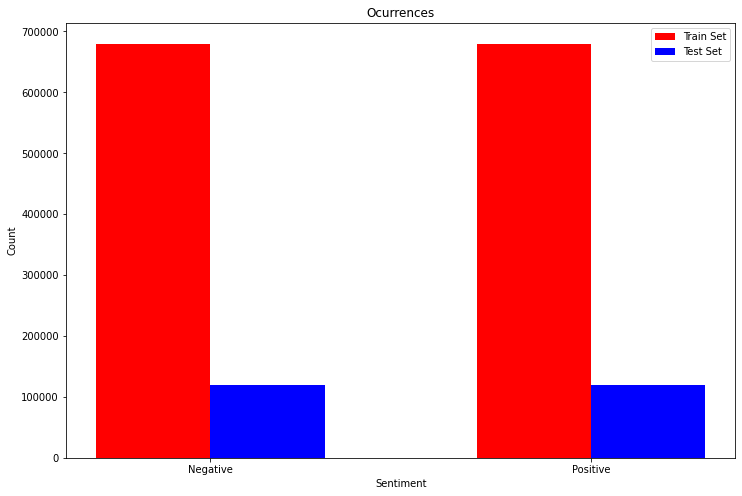

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(df.text.values, df.label.values, test_size = 0.15, random_state=17, stratify = df.label.values)

labels = [0, 1]
classes = ["Negative", "Positive"]
ocurrences_train = [len(Y_train) - np.sum(Y_train), np.sum(Y_train)]
ocurrences_test = [len(Y_test) - np.sum(Y_test), np.sum(Y_test)]

bar_width = 0.3
br_train = [x - bar_width / 2 for x in labels]
br_test = [x + bar_width / 2 for x in labels]

fig = plt.subplots(figsize=(12, 8))

plt.bar(br_train, ocurrences_train, width = bar_width, color="red", label="Train Set")
plt.bar(br_test, ocurrences_test, width = bar_width, color="blue", label="Test Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(labels, classes)
plt.title("Ocurrences")
plt.legend()
plt.show()

In [63]:
!pip install transformers

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [65]:
encoder_train = tokenizer.batch_encode_plus(X_train, add_special_tokens=True, pad_to_max_length=True, max_length=256, return_tensors="pt")
encoder_test = tokenizer.batch_encode_plus(X_test, add_special_tokens=True, pad_to_max_length=True, max_length=256, return_tensors="pt")

input_ids_train, attention_masks_train, labels_train = encoder_train["input_ids"], encoder_train["attention_mask"], torch.tensor(Y_train)
input_ids_test, attention_masks_test, labels_test = encoder_test["input_ids"], encoder_test["attention_mask"], torch.tensor(Y_test)

data_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_train = DataLoader(data_train, sampler=RandomSampler(data_train), batch_size=16)
dataloader_test = DataLoader(data_test, sampler=RandomSampler(data_test), batch_size=32)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [66]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, output_attentions=False, output_hidden_states=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

epochs = 1
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [67]:
def f1_score_func(
    preds,
    labels
    ):
  preds_flat, labels_flat = np.argmax(preds, axis=1).flatten(), labels.flatten()

  return f1_score(labels_flat, preds_flat, average="weighted")

def accuracy_per_class(
    preds,
    labels
    ):
  dict_label = {0: "Negative", 1: "Positive"}
  preds_flat, labels_flat = np.argmax(preds, axis=1).flatten(), labels.flatten()

  x = PrettyTable(["Class (Sentiment)", "Accuracy"])

  for label in np.unique(labels_flat):

    y_preds, y_true = preds_flat[labels_flat==label], labels_flat[labels_flat==label]
    x.add_row([dict_label[label], f"{len(y_preds[y_preds==label])}/{len(y_true)} ({round(100*len(y_preds[y_preds==label])/len(y_true), 2)}%)"])

  print(x)

def evaluate(
    dataloader_test
    ):
  model.eval()
  loss_test_total = 0
  predictions, targets = [], []
    
  for batch in tqdm(dataloader_test):

    batch = tuple(b.to(device) for b in batch) 
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}

    with torch.no_grad():
      
      outputs = model(**inputs)
      
    loss, logits = outputs[0], outputs[1]
    loss_test_total += loss.item()
    
    logits, label_ids = logits.detach().cpu().numpy(), inputs["labels"].cpu().numpy()
    predictions.append(logits)
    targets.append(label_ids)
        
  loss_test_avg = loss_test_total / len(dataloader_test)  
  predictions = np.concatenate(predictions, axis=0)
  targets = np.concatenate(targets, axis=0)

  return loss_test_avg, predictions, targets

In [68]:
for epoch in tqdm(range(1, epochs+1)):
  
  model.train()
  loss_train_total = 0
  progress_bar = tqdm(dataloader_train, desc="Epoch: {:1d}".format(epoch), leave=False, disable=False)
    
  for batch in progress_bar:
    
    model.zero_grad()
    batch = tuple(b.to(device) for b in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
    outputs = model(**inputs)
        
    loss = outputs[0]
    loss_train_total += loss.item()
    loss.backward()
        
    torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
    optimizer.step()
    lr_scheduler.step()
    
    progress_bar.set_postfix({"training_loss": "{:.3f}".format(loss.item()/len(batch))})

  tqdm.write(f"\nEpoch {epoch}")
    
  loss_train_avg = loss_train_total/len(dataloader_train)
  tqdm.write(f"Training Loss: {loss_train_avg}")
  test_loss, predictions, targets = evaluate(dataloader_test)
  test_score = f1_score_func(predictions, targets)
  tqdm.write(f"Test Loss: {test_loss}, Test Score: {test_score}")

torch.save(model.state_dict(), SAVE_FILE)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/85000 [00:00<?, ?it/s]


Epoch 1
Training Loss: 0.3265191525816698


  0%|          | 0/7500 [00:00<?, ?it/s]

Test Loss: 0.303360567560792, Test Score: 0.8726177228539644


In [69]:
model.load_state_dict(torch.load(SAVE_FILE))

_, predictions, targets = evaluate(dataloader_test)

accuracy_per_class(predictions, targets)

  0%|          | 0/7500 [00:00<?, ?it/s]

+-------------------+------------------------+
| Class (Sentiment) |        Accuracy        |
+-------------------+------------------------+
|      Negative     | 105622/120000 (88.02%) |
|      Positive     | 103808/120000 (86.51%) |
+-------------------+------------------------+


In [70]:
my_tweets = ["My girlfriend is a fantastic soccer player!", "That politician should go to prison, he has no morals...", "Who is down for a beer tonight? I'm feeling energetic :)", "Stop it John, you're not behaving appropriately."]
my_labels = [1, 0, 1, 0]

my_encoder = tokenizer.batch_encode_plus(my_tweets, add_special_tokens=True, pad_to_max_length=True, max_length=256, return_tensors="pt")
my_input_ids, my_attention_masks = my_encoder["input_ids"], my_encoder["attention_mask"]
my_input_ids, my_attention_masks, my_labels = torch.tensor(my_input_ids, dtype=torch.int64).view(len(my_tweets), -1).to(device), torch.tensor(my_attention_masks, dtype=torch.int64).view(len(my_tweets), -1).to(device), torch.tensor(my_labels, dtype=torch.int64).view(-1).to(device)
inputs = {"input_ids": my_input_ids, "attention_mask": my_attention_masks, "labels": my_labels}

model.eval()

with torch.no_grad():
  
  outputs = model(**inputs)
  
logits = outputs[1]
logits, label_ids = logits.detach().cpu().numpy(), inputs["labels"].cpu().numpy()
preds = np.argmax(logits, axis=1).flatten()

dict_label = {0: "Negative", 1: "Positive"}
x = PrettyTable(["Tweet", "Predicted Sentiment"])

for i in range(len(my_tweets)):

  x.add_row([my_tweets[i], dict_label[preds[i]]])

print(x)

+----------------------------------------------------------+---------------------+
|                          Tweet                           | Predicted Sentiment |
+----------------------------------------------------------+---------------------+
|       My girlfriend is a fantastic soccer player!        |       Positive      |
| That politician should go to prison, he has no morals... |       Negative      |
| Who is down for a beer tonight? I'm feeling energetic :) |       Positive      |
|     Stop it John, you're not behaving appropriately.     |       Negative      |
+----------------------------------------------------------+---------------------+
